In [0]:
print('Hello')

Hello


In [0]:
import matplotlib.pyplot as plt
import scipy.misc as scpm
import pandas as pd
import glob
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Activation

from sklearn.model_selection import train_test_split

from skimage import data, color
from skimage.transform import resize

%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
movie_posters_csv_path = "/content/gdrive/My Drive/final_movie_posters.csv"
posters_path = "/content/gdrive/My Drive/posters copy"
data = pd.read_csv(movie_posters_csv_path, encoding='latin')

In [0]:
data.head()

,Unnamed: 0,tid,title,action,scifi,drama,romance
0,0,tt1133993_0_6189,Serious Moonlight,False,False,False,True
1,1,tt0788135,Mini,False,False,False,True
2,2,tt0324554_0_5798,Wicker Park,False,False,True,True
3,3,tt1105747,Yuvvraaj,False,False,True,True
4,4,tt0841044_0_7411,2 Days in Paris,False,False,True,True


In [0]:
print(len(data))

6720


In [0]:
image_glob = glob.glob(posters_path + "/" + "*.jpg")
img_dict = {}
print(len(image_glob))

5962


In [0]:
def get_id(filename):
    
    index_s = filename.rfind("/t") + 3
    index_f = filename.rfind('.jpg')
    
    return filename[index_s:index_f]

In [0]:
def image_resize(image, size=(256, 224)):
    
    image = resize(image, size)
    image = image.astype(np.float32)
    image = (image / 255) 
    
    return image

In [0]:
tids_arr = data['tid']
len(tids_arr)

6720

THIS FUNCTION WAS WRITTEN LOCALLY TO RESIZE IMAGES TO LOWER QUALITY

NOT USED ON CLOUD SINCE THE RESIZED FOLDER WAS UPLOADED

def resize_save(save_path):
    
    #local_glob = glob(posters_path + '/' + '*.jpg')
    i = 0
    
    for path in image_glob:
        
        i += 1
        print("Image count: {}".format(i))
        
        img_save_path = save_path + '/' + get_tid(path) + '.jpg'
        image = scpm.imread(path)
        
        if (len(image.shape) != 3) or image.shape[2] == 4:
            continue
        
        image = image_resize(image, size=(280, 256))
        scpm.imsave(img_save_path, image)
    
    print("DONE")

In [0]:
def load_images():
  
  for image_path in image_glob:
    
    poster_id = get_id(image_path)
      
    try:
    
      img_dict[poster_id] = scpm.imread(image_path)
        
    except Exception as e:
      print(e)
      pass
    
  print("DONE")

In [0]:
load_images()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


DONE


In [0]:
print(len(img_dict))
img_keys = list(img_dict.keys())
print(len(img_keys))

5962
5962


In [0]:
def display_poster(poster_id):
  
    tid = "tt" + poster_id
    
    if poster_id not in img_keys:
      return
    
    row = data.loc[data['tid'] == tid]
    #print(row)
    title = row['title'].values[0]
    
    genre = ""
    
    action = row['action'].values[0]
    scifi = row['scifi'].values[0]
    drama = row['drama'].values[0]
    rom = row['romance'].values[0]
    
    if action:
        genre += '|Action|'
    if rom:
        genre += '|Romance|'
    if drama:
        genre += '|Drama|'
    if scifi:
        genre += '|Sci-Fi|'
        
    
    plt.title("{} \n {}".format(title, genre))
    plt.imshow(img_dict[poster_id])

    Unnamed: 0               tid           title  action  scifi  drama  \
99          99  tt0377752_0_2086  Dear Frankie     False  False   True   

    romance  
99     True  


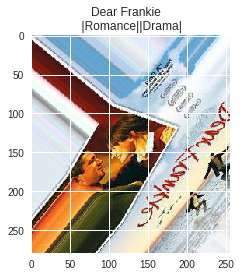

In [0]:
display_poster('0377752_0_2086')
#plt.imshow(img_dict['0324554_0_5798'])
row = data.loc[data['tid'] == 'tt0377752_0_2086']
print(row)

In [0]:
print(len(img_dict))

5962


In [0]:
def genres_per_movie(_id, data):
    
    row = data.loc[data['tid'] == 'tt' + _id]
    genres = []
    
    if row['action'].values[0]:
        genres.append('action')
    if row['scifi'].values[0]:
        genres.append('scifi')
    if row['drama'].values[0]:
        genres.append('drama')
    if row['romance'].values[0]:
        genres.append('romance')
    
    
    return genres

In [0]:
def prepare_data(data, img_dict, size=(256, 256)):
    
    dataset = []
    ids = []
    y = []
    
    label_dict = {'word2id': {'action':0, 'scifi': 1, 'drama': 2, 'romance': 3}, 'id2word': ['action', 'scifi', 'drama', 'romance']}
    num_classes = len(label_dict['id2word'])
    
    print(num_classes)
    
    num_samples = len(img_dict)
    
    print("Have {} samples".format(num_samples))
    
    for key in img_dict:
      
      try:

        genres = genres_per_movie(key, data)
        
        image = image_resize(img_dict[key], size)
        
        if image.shape != (256, 256, 3):
          continue
          
        one_hot_label = np.sum([np.eye(num_classes, dtype=np.uint8)[label_dict['word2id'][l]] for l in genres], axis = 0, dtype=np.uint8)
        
        dataset.append(image)
        y.append(one_hot_label)
        ids.append(key)
      
      except Exception as e:
          
        print(e)
        pass
        
      
    
    print("Only {} samples are fit for training".format(len(dataset)))
    print("DONE")
    
    return dataset, y, ids

In [0]:
dataset, y, ids = prepare_data(data, img_dict)

4
Have 5962 samples


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Only 5962 samples are fit for training
DONE


In [0]:
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.15)

In [0]:
#class_weights = {0:2, 1:2, 2:1, 3:3}

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(7,7), padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(32, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (1,1)))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(64, (5,5), padding='same'))
model.add(Conv2D(64, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (1,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (1,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (1,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(4, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

n = len(x_train)
history = model.fit(np.array(x_train[:n]), np.array(y_train[:n]), batch_size = 16, epochs = 12, verbose = 1, validation_split = 0.10, shuffle=True)

Train on 4560 samples, validate on 507 samples
Epoch 1/12
4560/4560 [==============================] - 82s 18ms/step - loss: 0.7373 - acc: 0.6184 - val_loss: 5.4357 - val_acc: 0.5039
Epoch 2/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6763 - acc: 0.6337 - val_loss: 3.3503 - val_acc: 0.5296
Epoch 3/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6654 - acc: 0.6372 - val_loss: 0.6628 - val_acc: 0.5804
Epoch 4/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6554 - acc: 0.6425 - val_loss: 1.9964 - val_acc: 0.5651
Epoch 5/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6549 - acc: 0.6431 - val_loss: 1.4552 - val_acc: 0.5528
Epoch 6/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6483 - acc: 0.6411 - val_loss: 0.6979 - val_acc: 0.6593
Epoch 7/12
4560/4560 [==============================] - 76s 17ms/step - loss: 0.6440 - acc: 0.6452 - val_loss: 0.6177 - val_acc: 0.6381
E

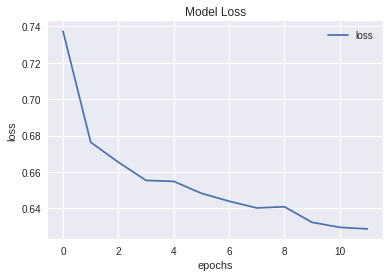

In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

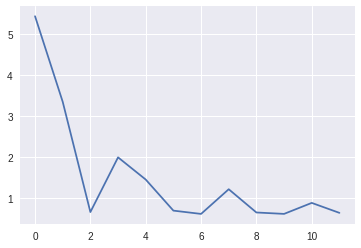

In [0]:
plt.plot(history.history['val_loss'])

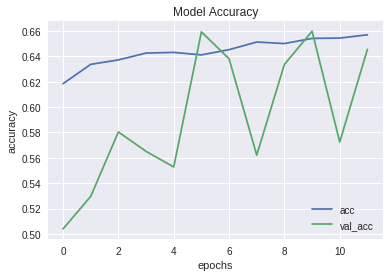

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model Accuracy")
plt.legend(['acc', 'val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [0]:
print(history.history['acc'])
print(history.history['val_acc'])

[0.618421052631579, 0.6336622807017543, 0.6371710526315789, 0.6425438596491229, 0.6430921052631579, 0.6411184210526316, 0.6452302631578948, 0.6512609649122807, 0.6500548245614035, 0.6541118421052632, 0.6543859649122807, 0.6569627192982456]
[0.5039447734106692, 0.5295857989341315, 0.5803747540394936, 0.5650887573964497, 0.5527613415167882, 0.6592702175503417, 0.6380670616142379, 0.5621301775147929, 0.6336291912039356, 0.6597633136094675, 0.5724852069830283, 0.6454635109656897]


In [0]:
test_loss, tset_acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=1)

895/895 [==============================] - 6s 7ms/step


In [0]:
print("Test loss: {} | Test accuracy: {}%".format(np.around(test_loss, 2), np.around(tset_acc * 100, 2)))

Test loss: 0.65 | Test accuracy: 64.44%


In [0]:
print("DONE")

DONE
